# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import sys

In [2]:
import torch

device = torch.device('cuda')
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

Tesla V100-DGXS-16GB


In [3]:
from logger import initialize_logger
logger = initialize_logger('../../../Logs/RuBert_AL.log', 'biomed_ie')
#initialize_logger('../workdir/logs/sequence_tagger_bert.log', 'sequence_tagger_bert')

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json

# Global parameters

In [5]:
CACHE_DIR = '../../../Cardio_files/Ru_bert_model/cache'

# MAX_LEN = 150
BATCH_SIZE = 32
#BATCH_SIZE = 16
MAX_LEN = 100
#BATCH_SIZE = 100
#BATCH_SIZE_PRED = 1200 # 1600
#BATCH_SIZE_PRED = 1200 # 1600
BATCH_SIZE_PRED = 1500
PRED_BATCH_SIZE = BATCH_SIZE_PRED
random_state = 2019

EARLY_STOPPING = 1
MAX_RETRAIN_EPOCHS = 30
#MAX_RETRAIN_EPOCHS = 10
MAX_N_EPOCHS = MAX_RETRAIN_EPOCHS

N_SAMPLES_PER_AL_ITER = 30
N_AL_PASSES = 10
N_AL_ITERATIONS = 25
# N_AL_PASSES = 1
# N_AL_ITERATIONS = 1

BASE_LR = 2e-5
LEARNING_RATE = BASE_LR

VALIDATION_RATIO = 0.25

MAX_TO_ANNEAL = 3
ANNEAL_FACTOR = 0.5
PATIENCE = 2
WEIGHT_DECAY = 0.01

SEED_POSITIVE = 10
SEED_RANDOM = 40

model_full_path = '../../../Cardio_files/Ru_bert_model/'
vocab = '../../../Cardio_files/Ru_bert_model/vocab.txt'

OUTPUT_FILE_PATH = '../../../experiments/'
#OUTPUT_FILE_PATH = '../workdir/experiments/debug'
#OUTPUT_FILE_PATH = '../workdir/experiments/debug'

# Load dataset

In [6]:
from flair.datasets import ColumnCorpus

corpora = {}

# data_folder = '../workdir/i2b2/conll/'
# for attr in ['hypertension', 'cad', 'diabetes']:
#     corpora[attr] = ColumnCorpus(data_folder, {0 : 'text', 1 : 'ner'},
#                                  train_file=f'i2b2_training_{attr}.conll',
#                                  test_file=f'i2b2_testing_{attr}.conll',
#                                  dev_file=f'i2b2_testing_{attr}.conll')

# data_folder = '../workdir/genia/conll/'
# corpora['genia'] = ColumnCorpus(data_folder, {0 : 'text', 1 : 'ner'},
#                                 train_file='Genia4ERtask1.iob2',
#                                 test_file='Genia4EReval1.iob2',
#                                 dev_file='Genia4EReval1.iob2')    
data_folder = '../../../Cardio_files/data/'

corpora["CardioLab"] = ColumnCorpus(data_folder, {0 : 'text', 1 : 'ner'},
                                 train_file='h2_train.txt',
                                    test_file = 'h2_test.txt',
                                 dev_file='h2_dev.txt')    

2020-02-19 12:48:57,849 Reading data from ../../../Cardio_files/data
2020-02-19 12:48:57,850 Train: ../../../Cardio_files/data/h2_train.txt
2020-02-19 12:48:57,851 Dev: ../../../Cardio_files/data/h2_dev.txt
2020-02-19 12:48:57,852 Test: ../../../Cardio_files/data/h2_test.txt


# Run experiments

In [7]:
from bert_active_learning_exp import run_experiment_al
from active_learning_seq import LibActNN, LibActNNPositiveLessCertain, RandomSamplingWithRetraining
from libact.query_strategies import UncertaintySampling, RandomSampling

from bert_sequence_tagger import SequenceTaggerBert, BertForTokenClassificationCustom, ModelTrainerBert
from bert_sequence_tagger.bert_utils import get_parameters_without_decay

from pytorch_transformers import BertTokenizer, AdamW, WarmupLinearSchedule, WarmupConstantSchedule
from torch.optim.lr_scheduler import ReduceLROnPlateau

from bert_sequence_tagger.metrics import f1_entity_level, f1_token_level


BERT_TOKENIZER = BertTokenizer.from_pretrained(vocab, 
                                               cache_dir=CACHE_DIR, 
                                               do_lower_case=False)

def create_libact_adaptor(tag2index, index2tag, adaptor_type, *args):
    def model_ctor():
        model = BertForTokenClassificationCustom.from_pretrained(model_full_path,
                                                                 cache_dir=CACHE_DIR, 
                                                                 num_labels=len(tag2index)).cuda()

        seq_tagger = SequenceTaggerBert(model, BERT_TOKENIZER, idx2tag=index2tag, tag2idx=tag2index)
        
        return seq_tagger
    
    def trainer_ctor(seq_tagger, corpus_len, train_dataloader, val_dataloader):
        optimizer = AdamW(get_parameters_without_decay(seq_tagger._bert_model),
                          lr=LEARNING_RATE, betas=(0.9, 0.999), 
                          eps=1e-6, weight_decay=0.01, correct_bias=True)

        lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=ANNEAL_FACTOR, patience=PATIENCE)
        
        trainer = ModelTrainerBert(seq_tagger, 
                                   optimizer, 
                                   lr_scheduler,
                                   train_dataloader, 
                                   val_dataloader,
                                   update_scheduler='ee',
                                   keep_best_model=True,
                                   restore_bm_on_lr_change=True,
                                   max_grad_norm=1.,
                                   validation_metrics=[f1_entity_level],
                                   decision_metric=lambda metrics: metrics[0],
                                   smallest_lr=LEARNING_RATE / (MAX_TO_ANNEAL**(1./ANNEAL_FACTOR) + 0.1))
        
        return trainer
    
    return adaptor_type(*args, 
                        model_ctor=model_ctor,
                        trainer_ctor=trainer_ctor,
                        batch_size=BATCH_SIZE,
                        bs_pred=BATCH_SIZE_PRED,
                        train_from_scratch=True,
                        retrain_epochs=MAX_RETRAIN_EPOCHS,
                        valid_ratio=VALIDATION_RATIO,
                        string_input=False)

In [9]:
def create_i2b2_experiment_pack(corpus, attr):
     return [
    {
        'corpus' : corpus,
        'output_file_path' : OUTPUT_FILE_PATH,
        'ranking_strategy' : lambda trn_ds, _libact_model: UncertaintySampling(trn_ds, model=_libact_model, method='lc'),
        'libact_adaptor_ctor' : lambda tag2index, index2tag: create_libact_adaptor(tag2index, index2tag, LibActNN),
        'name' : f'{attr}_MNLP',
        'n_passes' : N_AL_PASSES,
        'n_al_iterations' : N_AL_ITERATIONS,
        'max_len' : MAX_LEN,
        'max_samples_number' : N_SAMPLES_PER_AL_ITER,
        'seed_elems_per_class' : SEED_POSITIVE,
        'n_seeds_random' : SEED_RANDOM
    },
                  {
        'corpus' : corpus,
        'output_file_path' : OUTPUT_FILE_PATH,
        'ranking_strategy' : lambda trn_ds, _libact_model: RandomSamplingWithRetraining(trn_ds, model=_libact_model, method='lc'),
        'libact_adaptor_ctor' : lambda tag2index, index2tag: create_libact_adaptor(tag2index, index2tag, LibActNN),
        'name' : f'{attr}_i.i.d.',
        'n_passes' : N_AL_PASSES,
        'n_al_iterations' : N_AL_ITERATIONS,
        'max_len' : MAX_LEN,
        'max_samples_number' : N_SAMPLES_PER_AL_ITER,
        'seed_elems_per_class' : SEED_POSITIVE,
        'n_seeds_random' : SEED_RANDOM
    },
]


experiments = []
for attr, corpus in corpora.items():
    experiments += create_i2b2_experiment_pack(corpus, attr)

experiments

[{'corpus': <flair.datasets.ColumnCorpus at 0x7f0cc55d9518>,
  'output_file_path': '../../../experiments/',
  'ranking_strategy': <function __main__.create_i2b2_experiment_pack.<locals>.<lambda>(trn_ds, _libact_model)>,
  'libact_adaptor_ctor': <function __main__.create_i2b2_experiment_pack.<locals>.<lambda>(tag2index, index2tag)>,
  'name': 'CardioLab_MNLP',
  'n_passes': 10,
  'n_al_iterations': 25,
  'max_len': 100,
  'max_samples_number': 30,
  'seed_elems_per_class': 10,
  'n_seeds_random': 40},
 {'corpus': <flair.datasets.ColumnCorpus at 0x7f0cc55d9518>,
  'output_file_path': '../../../experiments/',
  'ranking_strategy': <function __main__.create_i2b2_experiment_pack.<locals>.<lambda>(trn_ds, _libact_model)>,
  'libact_adaptor_ctor': <function __main__.create_i2b2_experiment_pack.<locals>.<lambda>(tag2index, index2tag)>,
  'name': 'CardioLab_i.i.d.',
  'n_passes': 10,
  'n_al_iterations': 25,
  'max_len': 100,
  'max_samples_number': 30,
  'seed_elems_per_class': 10,
  'n_seeds_

In [ ]:
for exp in experiments:
    logger.info('#################### Experiment ######################')
    logger.info(exp)
    
    run_experiment_al(**exp)
    
    logger.info('################### Experiment finished ##############')

2020-02-19 12:49:52,417 - biomed_ie - INFO - #################### Experiment ######################
2020-02-19 12:49:52,418 - biomed_ie - INFO - {'corpus': <flair.datasets.ColumnCorpus object at 0x7f0cc55d9518>, 'output_file_path': '../../../experiments/', 'ranking_strategy': <function create_i2b2_experiment_pack.<locals>.<lambda> at 0x7f0cc55dfc80>, 'libact_adaptor_ctor': <function create_i2b2_experiment_pack.<locals>.<lambda> at 0x7f0c94faa598>, 'name': 'CardioLab_MNLP', 'n_passes': 10, 'n_al_iterations': 25, 'max_len': 100, 'max_samples_number': 30, 'seed_elems_per_class': 10, 'n_seeds_random': 40}
2020-02-19 12:49:52,621 - biomed_ie - INFO - Active learning...
2020-02-19 12:49:52,623 - biomed_ie - INFO - =============== Pass: 0 =============
2020-02-19 12:49:52,652 - biomed_ie - INFO - Number of seeding examples: 91
2020-02-19 12:49:52,653 - biomed_ie - INFO - Start emulating active learning.


Epoch: 100%|██████████| 30/30 [01:10<00:00,  2.35s/it]


2020-02-19 12:51:14,518 - biomed_ie - INFO - Performance on seed examples: {'f1_entity_level': 0.6858789625360231}
2020-02-19 12:51:14,519 - biomed_ie - INFO - Active learning iteration: #0


Epoch: 100%|██████████| 30/30 [01:22<00:00,  2.75s/it]


2020-02-19 12:52:54,019 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6823529411764706}
2020-02-19 12:52:54,021 - biomed_ie - INFO - Active learning iteration: #1


Epoch: 100%|██████████| 30/30 [01:41<00:00,  3.40s/it]


2020-02-19 12:54:52,171 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6705202312138727}
2020-02-19 12:54:52,173 - biomed_ie - INFO - Active learning iteration: #2


Epoch:  93%|█████████▎| 28/30 [01:54<00:08,  4.10s/it]


2020-02-19 12:57:07,067 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6763848396501457}
2020-02-19 12:57:07,069 - biomed_ie - INFO - Active learning iteration: #3


Epoch: 100%|██████████| 30/30 [02:22<00:00,  4.76s/it]


2020-02-19 12:59:45,254 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6627565982404692}
2020-02-19 12:59:45,256 - biomed_ie - INFO - Active learning iteration: #4


Epoch: 100%|██████████| 30/30 [02:44<00:00,  5.49s/it]


2020-02-19 13:02:44,863 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6686046511627908}
2020-02-19 13:02:44,864 - biomed_ie - INFO - Active learning iteration: #5


Epoch: 100%|██████████| 30/30 [03:03<00:00,  6.14s/it]


2020-02-19 13:06:03,216 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.686217008797654}
2020-02-19 13:06:03,217 - biomed_ie - INFO - Active learning iteration: #6


Epoch: 100%|██████████| 30/30 [03:25<00:00,  6.85s/it]


2020-02-19 13:09:42,668 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6842105263157896}
2020-02-19 13:09:42,669 - biomed_ie - INFO - Active learning iteration: #7


Epoch:  80%|████████  | 24/30 [02:59<00:45,  7.54s/it]


2020-02-19 13:13:03,485 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6801152737752162}
2020-02-19 13:13:03,486 - biomed_ie - INFO - Active learning iteration: #8


Epoch:  73%|███████▎  | 22/30 [02:58<01:04,  8.07s/it]


2020-02-19 13:16:22,423 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6938775510204083}
2020-02-19 13:16:22,425 - biomed_ie - INFO - Active learning iteration: #9


Epoch:  87%|████████▋ | 26/30 [03:50<00:35,  8.88s/it]


2020-02-19 13:20:34,780 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6840579710144926}
2020-02-19 13:20:34,781 - biomed_ie - INFO - Active learning iteration: #10


Epoch:  97%|█████████▋| 29/30 [04:41<00:09,  9.67s/it]


2020-02-19 13:25:37,595 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6627565982404692}
2020-02-19 13:25:37,597 - biomed_ie - INFO - Active learning iteration: #11


Epoch: 100%|██████████| 30/30 [05:11<00:00, 10.37s/it]


2020-02-19 13:30:59,776 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.6744186046511628}
2020-02-19 13:30:59,778 - biomed_ie - INFO - Active learning iteration: #12


Epoch: 100%|██████████| 30/30 [05:34<00:00, 11.14s/it]


2020-02-19 13:36:44,688 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.686046511627907}
2020-02-19 13:36:44,690 - biomed_ie - INFO - Active learning iteration: #13


Epoch:  93%|█████████▎| 28/30 [05:32<00:23, 11.88s/it]


2020-02-19 13:42:39,699 - biomed_ie - INFO - Performance: {'f1_entity_level': 0.686046511627907}
2020-02-19 13:42:39,701 - biomed_ie - INFO - Active learning iteration: #14


Epoch:  53%|█████▎    | 16/30 [03:23<02:57, 12.70s/it]

In [11]:
%matplotlib inline
from generate_chart import create_chart

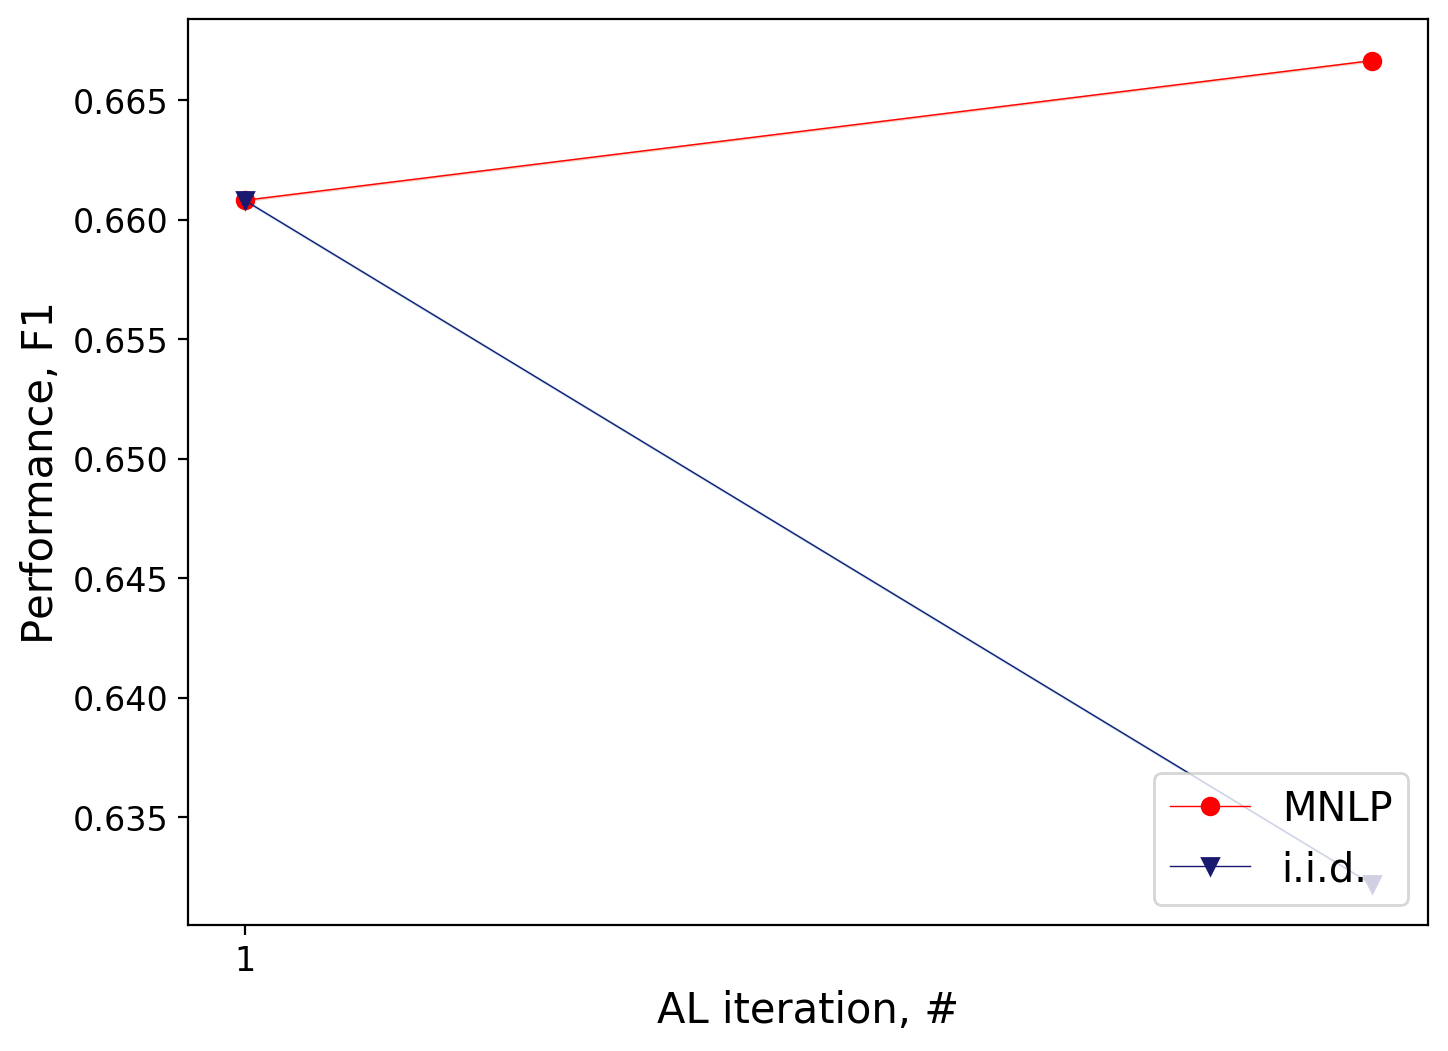

In [39]:
create_chart('../../../experiments/finalstats', 'CardioLab', save_dir='../../../experiments/Images')